# Generation and Evaluation of a Rule of Thumb for Dividing a Total Privacy Budget

In [2]:
from pets_utilities import *
from plotting_utilities import *

from scipy.optimize import curve_fit

from seaborn import heatmap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

### Creation of Synthetic Datasets -- Ran once. CSVs are located in ./simulations_data

In [3]:
'''

### The functions called in each of the pd.DataFrame can be found pets_utilities

## Uniform 
pd.DataFrame( uniform_hist(30, 3000) ).to_csv('./simulations_data/uniform_hist.csv', header=False)

## Left skewed
pd.DataFrame(left_skewed(70,10000)).to_csv('./simulations_data/left-skewed_hist.csv', header=False)

## Right skewed
pd.DataFrame(right_skewed(70,10000)).to_csv('./simulations_data/right-skewed_hist.csv', header=False)


## Symmetric bimodal
pd.DataFrame( np.array(binomial_hist(40, num_categories = 10000, p = 0.7)) + np.array(binomial_hist(40, num_categories = 10000, p = 0.3)) ).to_csv('./simulations_data/bimodal_hist.csv', header=False)

## Top-inflated distribution
pd.DataFrame(top_inflated(80, 10000)).to_csv('./simulations_data/top-inflated_hist.csv', header=False)

## Zero-inflated distribution
pd.DataFrame(zero_inflated(80, 10000)).to_csv('./simulations_data/zero-inflated_hist.csv', header=False)
'''



"\n\n### The functions called in each of the pd.DataFrame can be found pets_utilities\n\n## Uniform \npd.DataFrame( uniform_hist(30, 3000) ).to_csv('./simulations_data/uniform_hist.csv', header=False)\n\n## Left skewed\npd.DataFrame(left_skewed(70,10000)).to_csv('./simulations_data/left-skewed_hist.csv', header=False)\n\n## Right skewed\npd.DataFrame(right_skewed(70,10000)).to_csv('./simulations_data/right-skewed_hist.csv', header=False)\n\n\n## Symmetric bimodal\npd.DataFrame( np.array(binomial_hist(40, num_categories = 10000, p = 0.7)) + np.array(binomial_hist(40, num_categories = 10000, p = 0.3)) ).to_csv('./simulations_data/bimodal_hist.csv', header=False)\n\n## Top-inflated distribution\npd.DataFrame(top_inflated(80, 10000)).to_csv('./simulations_data/top-inflated_hist.csv', header=False)\n\n## Zero-inflated distribution\npd.DataFrame(zero_inflated(80, 10000)).to_csv('./simulations_data/zero-inflated_hist.csv', header=False)\n"

## Estimating the optimal split $f$ for a range of total privacy budgets

In [4]:
epsilon_split_datasets = {'uniform': list(pd.read_csv('./simulations_data/uniform_hist.csv', header=None)[1]),
                          'left-skewed': list(pd.read_csv('./simulations_data/left-skewed_hist.csv', header=None)[1]),
                          'right-skewed': list(pd.read_csv('./simulations_data/right-skewed_hist.csv', header=None)[1]),
                          'bimodal': list(pd.read_csv('./simulations_data/bimodal_hist.csv', header=None)[1]),
                          'top-inflated': list(pd.read_csv('./simulations_data/top-inflated_hist.csv', header=None)[1]),
                          'zero-inflated': list(pd.read_csv('./simulations_data/zero-inflated_hist.csv', header=None)[1]),
                         }

In [5]:
def epsilon_split_experiment(replications, emp_hists, simulate_run_functions, total_epsilons, fraction_epsilon_for_laplace = np.linspace(.9,.1,11), **kwargs):
    results = None
    for data_name, emp_hist in emp_hists.items():
        print("testing", data_name, end=" ")
        for total_epsilon in total_epsilons:
            print(np.round(total_epsilon,2),end=" ")
            laplace_epsilon_values = total_epsilon*fraction_epsilon_for_laplace
            counting_epsilon_values = total_epsilon - laplace_epsilon_values
            
            for laplace_epsilon, counting_epsilon in zip(laplace_epsilon_values, counting_epsilon_values):
                total_epsilon = counting_epsilon if laplace_epsilon == np.inf else counting_epsilon + laplace_epsilon
        
                for simulate_run_function in simulate_run_functions:
                    try:
                        sim_results = repeat_simulate_run(replications = replications,simulate_run_function = simulate_run_function, emp_hist = emp_hist, laplace_epsilon = laplace_epsilon, counting_epsilon = counting_epsilon, **kwargs)
                    except Exception as e:
                        print(e)
                    sim_results['dataset'] = data_name
                    sim_results['laplace_epsilon'] = laplace_epsilon
                    sim_results['counting_epsilon'] = counting_epsilon
                    sim_results['total_epsilon'] = total_epsilon
                    sim_results['epsilon_split'] = laplace_epsilon / total_epsilon
                    if results is None:
                        results = pd.DataFrame(sim_results, index = [0])
                    else:
                        results.loc[len(results)] = sim_results
        print('')
    return results

In [6]:
epsilon_split_simulate_run_functions = [create_simulate_run_from_constructor(sandwich_heuristic_constructor)]

In [7]:
np.random.seed(42)

total_epsilons = 10**np.linspace(-1, np.log10(5), 11)

epsilon_split_res = epsilon_split_experiment(replications= 20, 
                                     emp_hists = epsilon_split_datasets, 
                                     simulate_run_functions = epsilon_split_simulate_run_functions, 
                                     total_epsilons = total_epsilons,
                                     fraction_epsilon_for_laplace = np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9]))    

testing uniform 0.1 0.15 0.22 0.32 0.48 0.71 1.05 1.55 2.29 3.38 5.0 
0.15 0.22 0.32 0.48 0.71 1.05 1.55 2.29 3.38 5.0 
0.15 0.22 0.32 0.48 0.71 1.05 1.55 2.29 3.38 5.0 
0.15 0.22 0.32 0.48 0.71 1.05 1.55 2.29 3.38 5.0 
0.15 0.22 0.32 0.48 0.71 1.05 1.55 2.29 3.38 5.0 
0.15 0.22 0.32 0.48 0.71 1.05 1.55 2.29 3.38 5.0 


In [9]:
epsilon_split_rounded = epsilon_split_res.assign( total_epsilon = np.round(epsilon_split_res.total_epsilon, 3) )
epsilon_split_rounded = epsilon_split_rounded.assign( objective = np.log(epsilon_split_rounded['mean L1 noise']) + np.log(epsilon_split_rounded['mean wasserstein']))
optimal_f = epsilon_split_rounded.groupby(["dataset","total_epsilon"]).apply(lambda X: X.iloc[np.argmin(X.objective)][['epsilon_split']])
optimal_f.unstack(0)

epsilon_split                                                \
dataset             bimodal left-skewed right-skewed top-inflated uniform   
total_epsilon                                                               
0.100                   0.7         0.4          0.5          0.4     0.8   
0.148                   0.8         0.3          0.4          0.3     0.8   
0.219                   0.5         0.3          0.3          0.3     0.4   
0.323                   0.4         0.3          0.2          0.3     0.3   
0.478                   0.3         0.2          0.2          0.3     0.3   
0.707                   0.3         0.2          0.2          0.2     0.2   
1.046                   0.1         0.1          0.2          0.2     0.2   
1.546                   0.1         0.1          0.1          0.1     0.1   
2.287                   0.1         0.1          0.1          0.1     0.1   
3.381                   0.1         0.1          0.1          0.1     0.1   
5.000                   0.1         0.1          0.1          0.1     0.1   

                             
dataset       zero-inflated  
total_epsilon                
0.100                   0.3  
0.148                   0.3  
0.219                   0.3  
0.323                   0.2  
0.478                   0.2  
0.707                   0.2  
1.046                   0.1  
1.546                   0.1  
2.287                   0.1  
3.381                   0.1  
5.000                   0.1

In [ ]:
#optimal_f.unstack(0).to_csv('epsilon_split_experiment_doubleindexed.csv')

In [225]:
#optimal_f.to_csv('epsilon_split_experiment.csv')

## Fitting a Rule of Thumb to the Simulated Data

In [10]:
# Exponential decay model
def f_exp(x, A, B, K):
    return B + (A - B) * np.exp(-K * x)

In [11]:
def fit_exp_decay_multiindex(optimal_f):
    '''
    Fit y = B + (A - B) * exp(-K * x) to data in a DataFrame whose
    MultiIndex has x-values at level 1 and whose single column contains y-values.

    Constraints:
      0 <= A <= 1
      0 <= B <= 1
      K > 0

    Returns
    -------
    {
      'A': float, # y-intercept at x=0
      'B': float, # limit as x approaches positive infinity
      'K': float, # decay rate (>0)
      'cov': covariance matrix,
      'predict': callable f(x)->yhat
    }
    '''
    df = optimal_f.dropna()
    x = df.index.get_level_values(1).to_numpy(dtype=float)
    y = df.iloc[:, 0].to_numpy(dtype=float)

    ## Sort by x for numerical stability
    order = np.argsort(x)
    x, y = x[order], y[order]


    ## Initial guesses for estimation
    ymin, ymax = float(np.min(y)), float(np.max(y))
    A0 = np.clip(float(np.median(y[:max(3, len(y)//5)])), 0, 1)
    B0 = np.clip(float(np.median(y[-max(3, len(y)//5):])), 0, 1)

    ## Estimate K from multiple points
    K_candidates = []
    denom = (A0 - B0)
    if abs(denom) < 1e-12:
        K0 = 1.0
    else:
        for xi, yi in zip(x, y):
            if xi <= 0:
                continue
            r = (yi - B0) / denom
            if 1e-6 < r < 1 - 1e-6:
                K_est = -np.log(r) / xi
                if np.isfinite(K_est) and K_est > 0:
                    K_candidates.append(K_est)
        K0 = float(np.median(K_candidates)) if K_candidates else 1.0

    p0 = [A0, B0, K0]

    ## Bounds
    bounds = (
        [0.0, 0.0, 1e-9],  # lower bounds for (A, B, K)
        [1.0, 1.0, 1e3],   # upper bounds for (A, B, K)
    )

    ## Fit
    popt, pcov = curve_fit(
        f_exp, x, y, p0=p0, bounds=bounds, maxfev=200000
    )
    A_hat, B_hat, K_hat = map(float, popt)

    def predict(x_new):
        x_new = np.asarray(x_new, dtype=float)
        return f_exp(x_new, A_hat, B_hat, K_hat)

    return {
        "A": A_hat,
        "B": B_hat,
        "K": K_hat,
        "cov": pcov,
        "predict": predict,
    }


In [12]:
res = fit_exp_decay_multiindex(optimal_f)
A = res["A"]
B = res["B"]
K = res["K"]

print("Fitted Parameter Values: A =",np.round(A,3)," B =", np.round(B,3), " K =", np.round(K,3))

Fitted Parameter Values: A = 0.639  B = 0.106  K = 2.869


## Plot Performance of Rule of Thumb with Canonical Datasets

In [15]:
labels_count_error = {
    'sandwich_heuristic_constructor': 'Heuristic (Sandwich)',
    'max_heuristic_constructor': 'Heuristic (Max Selector)',
    'min_heuristic_constructor': 'Heuristic (Min Selector)',
    'interior_method_fixed_point_constructor': 'Count-Err-Min. Fixed-Point',
    'Unconstrained Optimum': 'Unconstrained Optimum',
    'unfixed_baseline_constructor': '2-Stage Unfixed Optimum',
    'truncated_geom': 'Trun Geom / Staircase',
    'discrete_gaussian': 'Discrete Gaussian'
}

### Binomial

In [16]:
np.random.seed(42)

binom_epsilon_split_res = pd.concat([epsilon_split_experiment(replications= 100, 
                                     emp_hists = {'binomial':binom_hist_dataset}, 
                                     simulate_run_functions = epsilon_split_simulate_run_functions, 
                                     total_epsilons = [total_epsilon],
                                     fraction_epsilon_for_laplace = np.sort(np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9, rule_of_thumb(total_epsilon)]))
                                                             )
                                     for total_epsilon in [0.1, 0.5, 1, 5]], axis = 0)

testing binomial 0.1 
testing binomial 0.5 
testing binomial 1 
testing binomial 5 


At total epsilon of 0.1 the measured optimality gap is 0.416
At total epsilon of 0.5 the measured optimality gap is 0.214
At total epsilon of 1.0 the measured optimality gap is 0.026
At total epsilon of 5.0 the measured optimality gap is 0.081


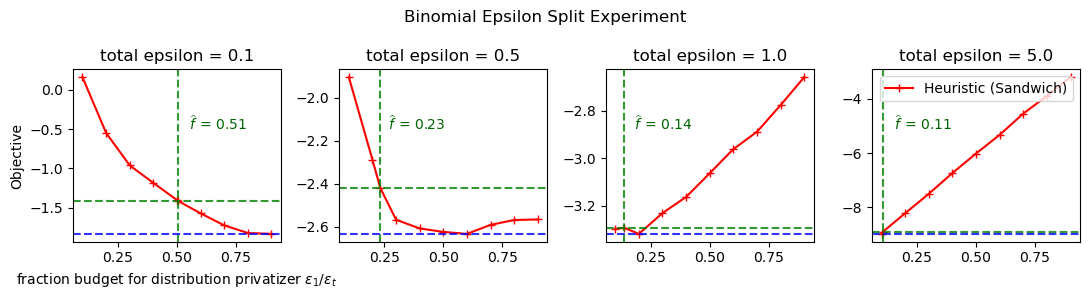

In [17]:
plotting_epsilons = binom_epsilon_split_res.total_epsilon.unique()

binom_epsilon_split_res = binom_epsilon_split_res.assign( objective = np.log(binom_epsilon_split_res['mean L1 noise']) + np.log(binom_epsilon_split_res['mean wasserstein']))

fig, ax = plt.subplots(1, len(plotting_epsilons), figsize=(11, 3))

for i, total_epsilon in enumerate(plotting_epsilons):
    for method in binom_epsilon_split_res.method.unique():
        temp = binom_epsilon_split_res[
            (binom_epsilon_split_res.method == method)
            & (binom_epsilon_split_res.total_epsilon == total_epsilon)
        ]

        ax[i].plot(
            temp["epsilon_split"],
            temp.objective,
            label=labels_count_error[method],
            marker=markers[method],
            linestyle=linestyles[method],
            color=colors[method],
        )

    objective_min = temp.iloc[np.argmin(temp.objective)].objective
    objective_rule_of_thumb = temp[np.abs(temp.epsilon_split - rule_of_thumb(total_epsilon)) <= 0.000001].objective.iloc[0]
    print("At total epsilon of", np.round(total_epsilon,3), "the measured optimality gap is", np.round(objective_rule_of_thumb - objective_min, 3))
    
    x_line = rule_of_thumb(total_epsilon)
    ax[i].axvline(x=x_line, color="green", linestyle="--", alpha=0.8)
    ax[i].text(x = x_line + (0.05 *(i == 0)), y = 0.65, s = '$\widehat f$ = ' + str(np.round(x_line, 2)), color = 'darkgreen', transform=ax[i].transAxes)

    ax[i].axhline(y=objective_rule_of_thumb, color="green", linestyle="--", alpha=0.8)
    ax[i].axhline(y=objective_min, color="blue", linestyle="--", alpha=0.8)
    
    ax[i].set_title(f"total epsilon = {np.round(total_epsilon, 3)}")

ax[0].set_xlabel("fraction budget for distribution privatizer $\\epsilon_1 / \\epsilon_t$")
ax[0].set_ylabel("Objective")

plt.legend(loc="upper right")
fig.suptitle("Binomial Epsilon Split Experiment")
plt.tight_layout()
plt.show()

### Crime -- Figure 8 in paper

In [18]:
np.random.seed(42)

crime_epsilon_split_res = pd.concat([epsilon_split_experiment(replications= 100, 
                                     emp_hists =  {'crime':crime_hist(crime_n)}, 
                                     simulate_run_functions = epsilon_split_simulate_run_functions, 
                                     total_epsilons = [total_epsilon],
                                     fraction_epsilon_for_laplace = np.sort(
                                         np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9, rule_of_thumb(total_epsilon)])
                                     )
                                                             )
                                     for total_epsilon in [0.1, 0.5, 1, 5]], axis = 0)

testing crime 0.1 
testing crime 0.5 
testing crime 1 
testing crime 5 


At total epsilon of 0.1 the measured optimality gap is 0.024
At total epsilon of 0.5 the measured optimality gap is 0.046
At total epsilon of 1.0 the measured optimality gap is 0.017
At total epsilon of 5.0 the measured optimality gap is 0.0


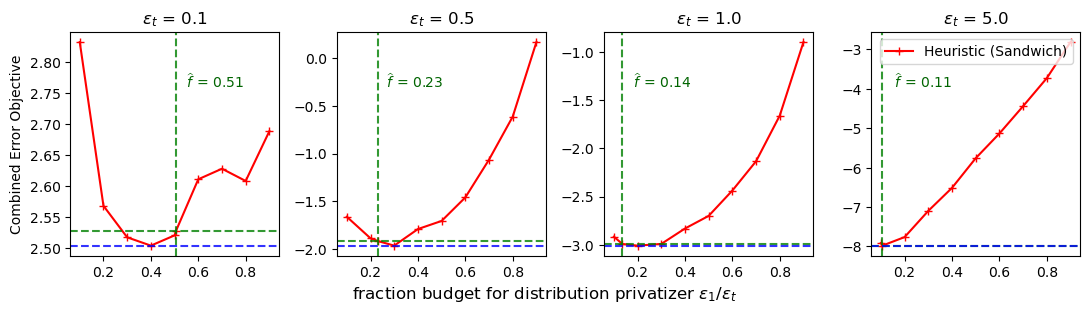

In [19]:
plotting_epsilons = crime_epsilon_split_res.total_epsilon.unique()

crime_epsilon_split_res = crime_epsilon_split_res.assign( objective = np.log(crime_epsilon_split_res['mean L1 noise']) + np.log(crime_epsilon_split_res['mean wasserstein']))

fig, ax = plt.subplots(1, len(plotting_epsilons), figsize=(11, 3))

for i, total_epsilon in enumerate(plotting_epsilons):
    for method in crime_epsilon_split_res.method.unique():
        temp = crime_epsilon_split_res[
            (crime_epsilon_split_res.method == method)
            & (crime_epsilon_split_res.total_epsilon == total_epsilon)
        ]

        ax[i].plot(
            temp["epsilon_split"],
            temp.objective,
            label=labels_count_error[method],
            marker=markers[method],
            linestyle=linestyles[method],
            color=colors[method],
        )

        
    objective_min = temp.iloc[np.argmin(temp.objective)].objective
    objective_rule_of_thumb = temp[np.abs(temp.epsilon_split - rule_of_thumb(total_epsilon)) <= 0.000001].objective.iloc[0]
    print("At total epsilon of", np.round(total_epsilon,3), "the measured optimality gap is", np.round(objective_rule_of_thumb - objective_min, 3))
    
    x_line = rule_of_thumb(total_epsilon)
    ax[i].axvline(x=x_line, color="green", linestyle="--", alpha=0.8)
    ax[i].text(x = x_line + (0.05 *(i == 0)), y = 0.75, s = '$\widehat f$ = ' + str(np.round(x_line, 2)), color = 'darkgreen', transform=ax[i].transAxes)

    ax[i].axhline(y=objective_rule_of_thumb, color="green", linestyle="--", alpha=0.8)
    ax[i].axhline(y=objective_min, color="blue", linestyle="--", alpha=0.8)
    
    ax[i].set_title(f"$\epsilon_t$ = {np.round(total_epsilon, 3)}")

ax[0].set_ylabel("Combined Error Objective")

fig.text(0.5, 0.0001, 'fraction budget for distribution privatizer $\\epsilon_1 / \\epsilon_t$', ha='center', va='center', fontsize=12)

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

#plt.savefig('epsilon_split.png', bbox_inches='tight', dpi = 300)

### Schools

In [20]:
np.random.seed(42)

schools_epsilon_split_res = pd.concat([epsilon_split_experiment(replications= 100, 
                                     emp_hists =  {'schools':schools_hist(schools_n)}, 
                                     simulate_run_functions = epsilon_split_simulate_run_functions, 
                                     total_epsilons = [total_epsilon],
                                     fraction_epsilon_for_laplace = np.sort(
                                         np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9, rule_of_thumb(total_epsilon)])
                                     )
                                                             )
                                     for total_epsilon in [0.1, 0.5, 1, 5]], axis = 0)

testing schools 0.1 
testing schools 0.5 
testing schools 1 
testing schools 5 


At total epsilon of 0.1 the measured optimality gap is 0.135
At total epsilon of 0.5 the measured optimality gap is 0.172
At total epsilon of 1.0 the measured optimality gap is 0.057
At total epsilon of 5.0 the measured optimality gap is 0.081


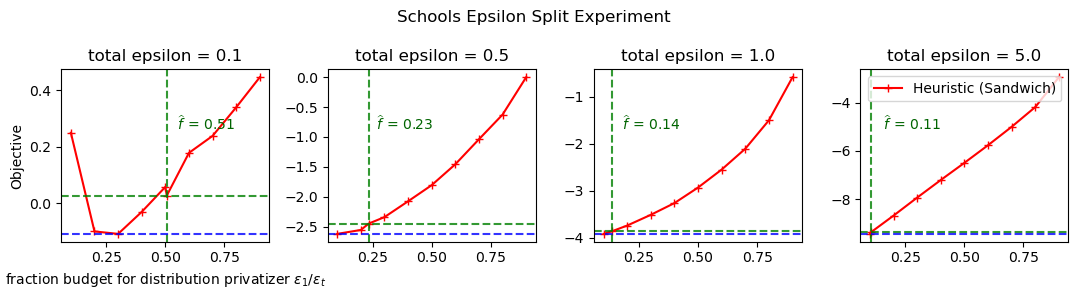

In [21]:
plotting_epsilons = schools_epsilon_split_res.total_epsilon.unique()

schools_epsilon_split_res = schools_epsilon_split_res.assign( objective = np.log(schools_epsilon_split_res['mean L1 noise']) + np.log(schools_epsilon_split_res['mean wasserstein']))

fig, ax = plt.subplots(1, len(plotting_epsilons), figsize=(11, 3))

for i, total_epsilon in enumerate(plotting_epsilons):
    for method in schools_epsilon_split_res.method.unique():
        temp = schools_epsilon_split_res[
            (schools_epsilon_split_res.method == method)
            & (schools_epsilon_split_res.total_epsilon == total_epsilon)
        ]

        ax[i].plot(
            temp["epsilon_split"],
            temp.objective,
            label=labels_count_error[method],
            marker=markers[method],
            linestyle=linestyles[method],
            color=colors[method],
        )

    
    objective_min = temp.iloc[np.argmin(temp.objective)].objective
    objective_rule_of_thumb = temp[np.abs(temp.epsilon_split - rule_of_thumb(total_epsilon)) <= 0.000001].objective.iloc[0]
    print("At total epsilon of", np.round(total_epsilon,3), "the measured optimality gap is", np.round(objective_rule_of_thumb - objective_min, 3))
    
    x_line = rule_of_thumb(total_epsilon)
    ax[i].axvline(x=x_line, color="green", linestyle="--", alpha=0.8)
    ax[i].text(x = x_line + (0.05 *(i == 0)), y = 0.65, s = '$\widehat f$ = ' + str(np.round(x_line, 2)), color = 'darkgreen', transform=ax[i].transAxes)

    ax[i].axhline(y=objective_rule_of_thumb, color="green", linestyle="--", alpha=0.8)
    ax[i].axhline(y=objective_min, color="blue", linestyle="--", alpha=0.8)

    ax[i].set_title(f"total epsilon = {np.round(total_epsilon, 3)}")

ax[0].set_xlabel("fraction budget for distribution privatizer $\\epsilon_1 / \\epsilon_t$")
ax[0].set_ylabel("Objective")

plt.legend(loc="upper right")
fig.suptitle("Schools Epsilon Split Experiment")
plt.tight_layout()
plt.show()